In [1]:
# Install GDAL and deepdespeckling
!apt-get install -y gdal-bin python-gdal python3-gdal
!pip install deepdespeckling


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 13.3 MB/s eta 0:00:00


In [2]:
from deepdespeckling.merlin.merlin_denoiser import MerlinDenoiser
from deepdespeckling.sar2sar.sar2sar_denoiser import Sar2SarDenoiser
import numpy as np
import matplotlib.pyplot as plt
import cv2  # To read PNG images in grayscale format


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your 256x256 grayscale PNG image
image_path = '/content/drive/MyDrive/input_image.png'


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/deepdespeckling/merlin/merlin_denoiser.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
100%|██

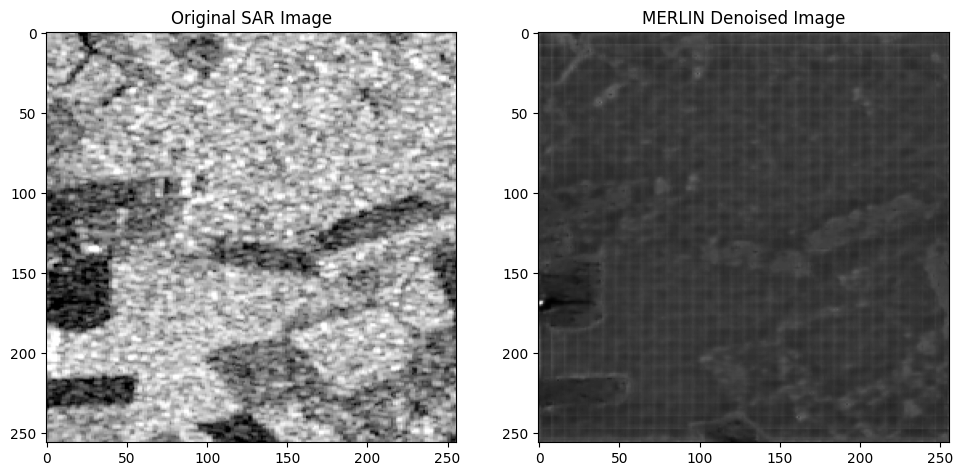

In [4]:
#Load Image and Prepare for MERLIN
# Load the grayscale PNG image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image loaded correctly
if image is None:
    print("Error: Image not found or path is incorrect.")
else:
    # Convert to float32
    image = image.astype(np.float32)

    # Ensure the image has two channels by duplicating the single channel
    image = np.stack((image, image), axis=-1)  # Shape will be (256, 256, 2)

    # Initialize MERLIN with Tuning Options and Perform Despeckling
    # Set parameters for tuning
    patch_size = 32   # Experiment with values like 64, 128, etc.
    stride_size = 8     # Experiment with values like 32, 64, etc.
    symmetrize = False   # Set to False to test effect on the output
    model_type = "Sentinel-TOPS"  # Options: "spotlight", "stripmap", "Sentinel-TOPS"

    # Initialize MERLIN denoiser with tuned parameters
    merlin_denoiser = MerlinDenoiser(model_name=model_type, symetrise=symmetrize)

    # Perform despeckling with specified patch and stride size
    denoised_image_merlin = merlin_denoiser.denoise_image(image, patch_size=patch_size, stride_size=stride_size)

    # Extract Denoised Image and Apply Optional Smoothing
    # Access the "full" denoised image array
    denoised_image = denoised_image_merlin["denoised"]["full"]

    # Display Original, Denoised, and Smoothed Images Side-by-Side
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original SAR Image")
    plt.imshow(image[..., 0], cmap='gray')  # Display one channel for visualization

    plt.subplot(1, 3, 2)
    plt.title("MERLIN Denoised Image")
    plt.imshow(denoised_image, cmap='gray')

    output_path = '/content/drive/MyDrive/output_image.png'
    cv2.imwrite(output_path, denoised_image.astype(np.uint8))
